In [48]:
import numpy as np
import warnings, scipy
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.gridspec import GridSpec
import seaborn as sns
from datetime import datetime as dt
import dateutil
from scipy.optimize import curve_fit
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
warnings.filterwarnings("ignore")


In [2]:
!pip freeze > requirements.txt

# Limpieza y Transformacion

Nombres de columnas a variables

In [49]:
FechaI = 'Fecha-I' # Fecha y hora programada de vuelo
VueloI = 'Vlo-I' # Numero de vuelo programado
OrigenI = 'Ori-I' # Codigo de ciudad de origen programado
DesI = 'Des-I' # Codigo de ciudad de destino programado
EmpI = 'Emp-I' # Codigo aerolinea vuelo programado
FechaO = 'Fecha-O' # Fecha y hora de operacion del vuelo
VueloO = 'Vlo-O' # Numero de vuelo de operacion del vuelo
OriO = 'Ori-O' #Codigo de ciudad de origen de operacion
DesO = 'Des-O' #Codigo de ciudad destino de operacion 
EmpO = 'Emp-O' # Codigo aerolinea de vuelo operado
Dia = 'DIA' # Dia del mes de operacion del vuelo
Mes = 'MES' # numero de mes de operacion del vuelo
ANO = 'ANO' # ano de operacion del vuelo
Dianom = 'DIANOM' # Dia de la semana de operacion del vuelo 
Tipov = 'TIPOVUELO' # tipo vuelo 1=Internacional, 0 = Nacional
Opera = 'OPERA' # Nombre de aerolinea que opera
SiglaO = 'SIGLAORI' # Nombre de ciudad Origen
SiglaD = 'SIGLADES' # Nombre de ciudad destino

Cambiar las columnas Vlo-I y Vlo-O a string, habia mas de un tipo dentro de la columna

In [50]:
dtypes = {VueloI:str,VueloO:str }

Leer dataframe, convertir Fecha-I y Fecha-O a datetime 

In [51]:
df = pd.read_csv("https://raw.githubusercontent.com/LEON240196/ChallengeLatam/main/dataset_SCL.csv", parse_dates=['Fecha-I', 'Fecha-O'],dtype=dtypes)

In [52]:
df[ANO] = df['AÑO']
df.drop('AÑO',axis='columns', inplace=True)

Ningun campo esta vacio o tiene valores nulos

In [53]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68206 entries, 0 to 68205
Data columns (total 18 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Fecha-I    68206 non-null  datetime64[ns]
 1   Vlo-I      68206 non-null  object        
 2   Ori-I      68206 non-null  object        
 3   Des-I      68206 non-null  object        
 4   Emp-I      68206 non-null  object        
 5   Fecha-O    68206 non-null  datetime64[ns]
 6   Vlo-O      68205 non-null  object        
 7   Ori-O      68206 non-null  object        
 8   Des-O      68206 non-null  object        
 9   Emp-O      68206 non-null  object        
 10  DIA        68206 non-null  int64         
 11  MES        68206 non-null  int64         
 12  DIANOM     68206 non-null  object        
 13  TIPOVUELO  68206 non-null  object        
 14  OPERA      68206 non-null  object        
 15  SIGLAORI   68206 non-null  object        
 16  SIGLADES   68206 non-null  object       

Observar cuantas aerolineas son, podemos observar que Grupo Latam constituye el 60% del dataset, seguido por sky airline con un 20.9 %

In [54]:
df['MES'] = df['MES'].astype('category')
df['DIA'] = df['DIA'].astype('category')

In [55]:
df.OPERA.value_counts(normalize=True)[:5]

Grupo LATAM              0.599537
Sky Airline              0.209630
Aerolineas Argentinas    0.028575
Copa Air                 0.027124
Latin American Wings     0.024543
Name: OPERA, dtype: float64

In [56]:
global_stats = df.OPERA.value_counts()
global_stats[:5]

Grupo LATAM              40892
Sky Airline              14298
Aerolineas Argentinas     1949
Copa Air                  1850
Latin American Wings      1674
Name: OPERA, dtype: int64

Crear columna Booleana para temporada alta

In [11]:
df['temporada_alta'] = df['Fecha-I'].apply(lambda x: 1 if ((x> dt(2016,12,15)
 and x<dt(2017,3,3)) or (x>dt(2017,7,15) and x<dt(2017,7,31)) or ( x>dt(2017,9,11)
 and x<dt(2017,9,30))) else 0)

Crear columnas diferencia de minutos y atraso_15 min

In [12]:
df['dif_min'] = df['Fecha-O'] - df['Fecha-I']
df['dif_min'] = df['dif_min'].apply(lambda x: x.total_seconds()/60)
df['atraso_15'] = df['dif_min'].apply(lambda x: 1 if x>15 else 0)

Diccionario para mapear la hora del dia

In [13]:
periodo = {0:'noche',1:'noche', 2:'noche', 3:'noche', 4:'noche'
, 5:'manana', 6:'manana', 7:'manana', 8:'manana', 9:'manana'
, 10:'manana', 11:'manana', 12:'tarde', 13:'tarde', 14:'tarde'
, 15:'tarde', 16:'tarde', 17:'tarde', 18:'tarde', 19:'noche'
, 20:'noche', 21:'noche', 22:'noche', 23:'noche', 24:'noche'}

Crear columna periodo_dia

In [14]:
df['periodo_dia'] = df['Fecha-I'].dt.hour
df['periodo_dia'] = df['periodo_dia'].map(periodo)

Creacion columna para la estacion del ano

In [15]:
df['Season'] = df['Fecha-I'].apply(lambda x: 'Invierno' if  (x > dt(2016,12,1) and x < dt(2017,3,1)) 
                                   else'Primavera' if (x> dt(2017,3,1) and x < dt(2017,6,1)) 
                                   else 'Verano' if (x> dt(2017,6,1) and x < dt(2017,11,1)) 
                                   else 'Otono' if (x> dt(2017,11,1) and x < dt(2018,1,15)) else 0)

Podemos observar que el 41 % de los vuelos son en verano, seguido por primavera con 23 %, 18% Otono y 17% Invierno

In [16]:
df.Season.value_counts(normalize=True)

Verano       0.415785
Primavera    0.230771
Otono        0.182359
Invierno     0.171085
Name: Season, dtype: float64

<AxesSubplot:xlabel='Season', ylabel='count'>

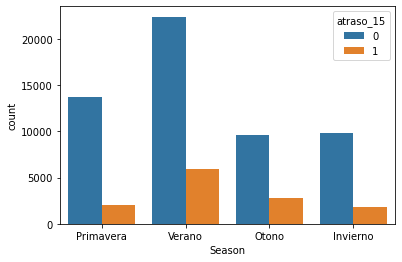

In [17]:
sns.countplot(x='Season', data=df, hue='atraso_15', order=['Primavera', 'Verano', 'Otono', 'Invierno'])

# Exploratory Data Analysis

Observar como estan distribuidos por periodo_dia y numero de records

In [18]:
df.periodo_dia.value_counts()

tarde     25506
manana    25352
noche     17348
Name: periodo_dia, dtype: int64

Hay mayor cantidad de vuelos en la tarde/manana que en la noche

<AxesSubplot:xlabel='periodo_dia', ylabel='count'>

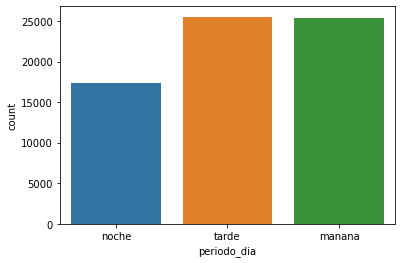

In [19]:
sns.countplot(x=df.periodo_dia)

El 81 % de vuelos en el df tienen un tiempo menor a 15 minutos de retraso, y el 1% que resta si

In [20]:
df.atraso_15.value_counts(normalize=True)

0    0.81506
1    0.18494
Name: atraso_15, dtype: float64

Creamos diccionario de nombre de aerolinea junto con su codigo

In [21]:
df3 = df[['OPERA', 'Emp-O']]
df3 = df3.set_index('Emp-O')['OPERA'].to_dict()

In [22]:
df3

{'AAL': 'American Airlines',
 'ACA': 'Air Canada',
 'AFR': 'Air France',
 'AMX': 'Aeromexico',
 'ARG': 'Aerolineas Argentinas',
 'AUT': 'Austral',
 'AVA': 'Avianca',
 'AZA': 'Alitalia',
 'BAW': 'British Airways',
 'CMP': 'Copa Air',
 'DAL': 'Delta Air',
 'GLO': 'Gol Trans',
 'IBE': 'Iberia',
 'KLM': 'K.L.M.',
 'LRC': 'Lacsa',
 'QFA': 'Qantas Airways',
 'UAL': 'United Airlines',
 'LAP': 'Grupo LATAM',
 'TAM': 'Grupo LATAM',
 'SKU': 'Sky Airline',
 'LAN': 'Grupo LATAM',
 'LXP': 'Grupo LATAM',
 'LNE': 'Grupo LATAM',
 'LPE': 'Grupo LATAM',
 'DSM': 'Grupo LATAM',
 '48O': 'Latin American Wings',
 '56R': 'Latin American Wings',
 'JMR': 'Latin American Wings',
 'PUE': 'Plus Ultra Lineas Aereas',
 'JAT': 'JetSmart SPA',
 'TPU': 'Avianca',
 'ONE': 'Oceanair Linhas Aereas'}

Lo mismo que el df3, pero al reves

In [23]:
df2 = df.loc[:, ['OPERA', 'dif_min']]
df2['OPERA'] = df2['OPERA'].replace(df3)

Creacion de grafica circular para el % de vuelos en la compania 

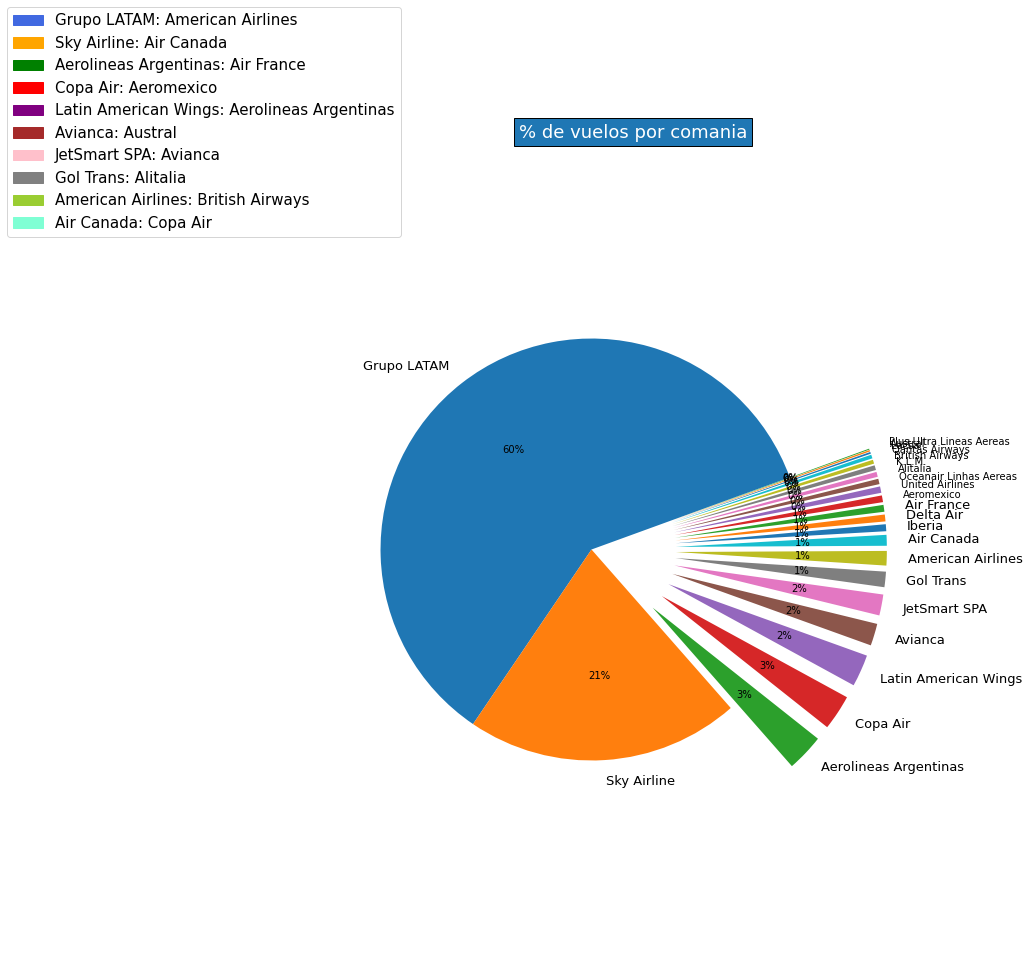

In [24]:
fig = plt.figure(1, figsize=(10,15))
ax1=fig.subplots() 


labels = [s for s in  global_stats.index[:]]
sizes  = global_stats.values[:]
explode = [0.0 if sizes[i] > 2000 else 0.4 for i in range(len(df.OPERA.unique()[:]))]
patches, texts, autotexts = ax1.pie(sizes,
                    labels=labels,explode=explode,  autopct='%1.0f%%',
                    shadow=False, startangle=20)

for i in range(len(df.OPERA.unique()[:])): 
    texts[i].set_fontsize(10)
for i in range(len(df.OPERA.unique()[10:])): 
     texts[i].set_fontsize(13)
ax1.axis('equal')
ax1.set_title('% de vuelos por comania', bbox={'pad':5},
              color = 'w',fontsize=18)
colors = ['royalblue', 'orange', 'green', 'r', 'purple', 'brown', 'pink',
          'gray', 'yellowgreen', 'aquamarine']
comp_handler = []
for i in range(len(df.OPERA.unique()[:10])):
    comp_handler.append(mpatches.Patch(color=colors[i],
            label = global_stats.index[i] + ': ' + df.OPERA.unique()[i]))
ax1.legend(handles=comp_handler, bbox_to_anchor=(0.2, 0.9), 
    fontsize = 15, bbox_transform=plt.gcf().transFigure, loc=5)

Scatterplot para ver como estan distribuidos los tiempos de retraso, por aerolina operadora

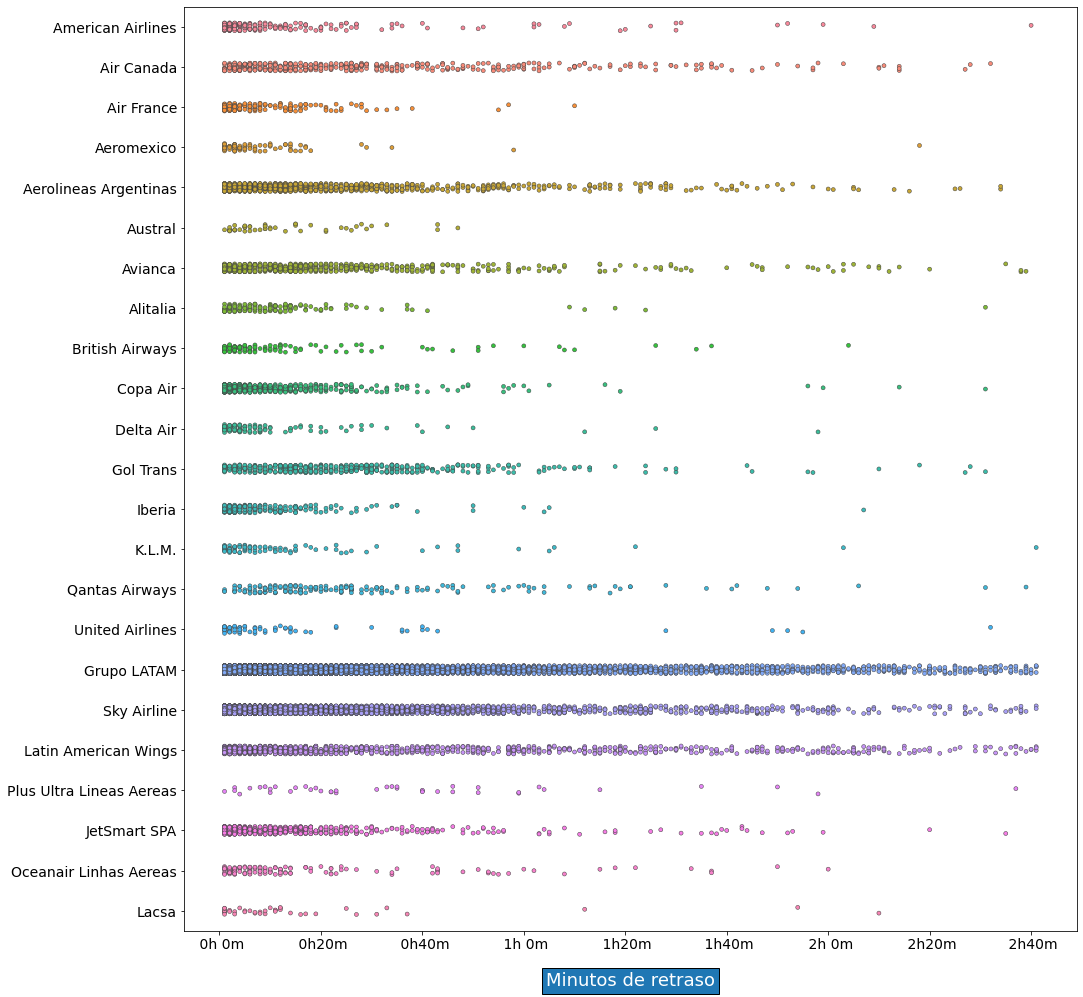

In [25]:
fig = plt.figure(1, figsize=(16,17))
ax3=fig.subplots()
sns.stripplot(y="OPERA", x="dif_min", size = 4,
                    data=df[df.dif_min>0], linewidth = 0.5,  jitter=True,)  #hue='temporada_alta')
plt.setp(ax3.get_xticklabels(), fontsize=14)
plt.setp(ax3.get_yticklabels(), fontsize=14)
ax3.set_xticklabels(['{:2.0f}h{:2.0f}m'.format(*[int(y) for y in divmod(x,60)])
                        for x in ax3.get_xticks()])
plt.xlabel('Minutos de retraso', fontsize=18, bbox={},
           color='w', labelpad=20)
ax3.yaxis.label.set_visible(False)

Creamos otra columna dif_nivel donde divide el tiempo de retraso en 3, a tiempo, 
retraso corto o largo.

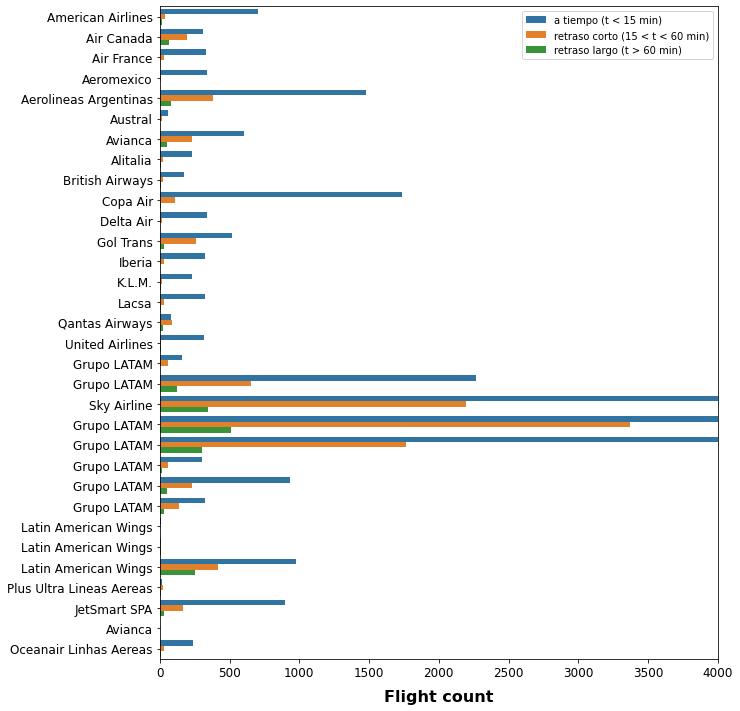

In [26]:
delay_type = lambda x:((0,1)[x > 15],2)[x > 60]

df['dif_nivel'] = df['dif_min'].apply(delay_type)
#____________________________________________________
fig = plt.figure(1, figsize=(10,12))
ax = sns.countplot(y="Emp-O", hue='dif_nivel', data=df)
#____________________________________________________________________________________
# We replace the abbreviations by the full names of the companies and set the labels
labels = [df3[item.get_text()] for item in ax.get_yticklabels()]
ax.set_yticklabels(labels)
plt.setp(ax.get_xticklabels(), fontsize=12, weight = 'normal', rotation = 0)
plt.setp(ax.get_yticklabels(), fontsize=12, weight = 'normal', rotation = 0)
ax.yaxis.label.set_visible(False)
plt.xlabel('Flight count', fontsize=16, weight = 'bold', labelpad=10)
plt.xlim([0,4000])
L = plt.legend()
L.get_texts()[0].set_text('a tiempo (t < 15 min)')
L.get_texts()[1].set_text('retraso corto (15 < t < 60 min)')
L.get_texts()[2].set_text('retraso largo (t > 60 min)')
plt.show()



EL 15.5 % de los retrasos son entre 15 y 60 minutos, el otro 3 % son arriba de 1 hora

In [27]:
df.dif_nivel.value_counts(normalize=True)

0    0.815060
1    0.155895
2    0.029044
Name: dif_nivel, dtype: float64

Creamos diccionario con Sigla de Empresa operadora y nombre de empresa

In [28]:
df4 = df[['OPERA', 'Emp-O']]
df4 = df4.set_index('Emp-O')['OPERA'].to_dict()

In [29]:
df4

{'AAL': 'American Airlines',
 'ACA': 'Air Canada',
 'AFR': 'Air France',
 'AMX': 'Aeromexico',
 'ARG': 'Aerolineas Argentinas',
 'AUT': 'Austral',
 'AVA': 'Avianca',
 'AZA': 'Alitalia',
 'BAW': 'British Airways',
 'CMP': 'Copa Air',
 'DAL': 'Delta Air',
 'GLO': 'Gol Trans',
 'IBE': 'Iberia',
 'KLM': 'K.L.M.',
 'LRC': 'Lacsa',
 'QFA': 'Qantas Airways',
 'UAL': 'United Airlines',
 'LAP': 'Grupo LATAM',
 'TAM': 'Grupo LATAM',
 'SKU': 'Sky Airline',
 'LAN': 'Grupo LATAM',
 'LXP': 'Grupo LATAM',
 'LNE': 'Grupo LATAM',
 'LPE': 'Grupo LATAM',
 'DSM': 'Grupo LATAM',
 '48O': 'Latin American Wings',
 '56R': 'Latin American Wings',
 'JMR': 'Latin American Wings',
 'PUE': 'Plus Ultra Lineas Aereas',
 'JAT': 'JetSmart SPA',
 'TPU': 'Avianca',
 'ONE': 'Oceanair Linhas Aereas'}

In [30]:
# for carrier_name in [df3[x] for x in global_stats.index]:
#     print(carrier_name)

In [31]:
global_stats2 = df['Emp-O'].value_counts()
global_stats2

LAN    20988
LXP    14558
SKU    14298
TAM     3046
ARG     1946
CMP     1850
JMR     1647
LPE     1214
JAT     1095
AVA      885
GLO      806
AAL      757
ACA      565
DSM      493
LNE      374
IBE      362
AFR      358
DAL      358
LRC      357
AMX      351
UAL      335
ONE      279
AZA      259
KLM      251
LAP      219
BAW      205
QFA      195
AUT       77
PUE       49
56R       17
48O       10
TPU        2
Name: Emp-O, dtype: int64

Las siguientes graficas nos demuestra la distribucion de retraso de todas las aerlineas

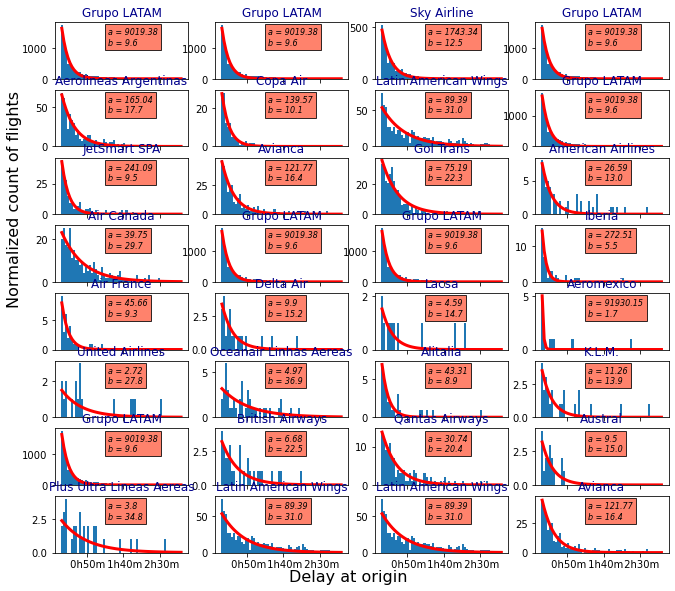

In [32]:
# Model function used to fit the histograms
def func(x, a, b):
    return a * np.exp(-x/b)
#-------------------------------------------
points = [] ; label_company = []
fig = plt.figure(1, figsize=(11,11))
i = 0
for carrier_name in [df4[x] for x in global_stats2.index]:
    i += 1
    ax = fig.add_subplot(9,4,i)
    #_________________________
    # Fit of the distribution
    n, bins, patches = plt.hist(x = df[df['OPERA']==carrier_name]['dif_min'],
            range = (15,180), bins= 60)
    bin_centers = bins[:-1] + 0.5 * (bins[1:] - bins[:-1])    
    popt, pcov = curve_fit(func, bin_centers, n, p0 = [1, 2])
    #___________________________ bookeeping of the results
    points.append(popt)
    label_company.append(carrier_name)
    #______________________
    # draw the fit curve
    plt.plot(bin_centers, func(bin_centers, *popt), 'r-', linewidth=3)  
    
#     # define tick labels for each subplot
    if i < 29:
        ax.set_xticklabels(['' for x in ax.get_xticks()])
    else:
        ax.set_xticklabels(['{:2.0f}h{:2.0f}m'.format(*[int(y) for y in divmod(x,60)])
                            for x in ax.get_xticks()])
#     #______________
#     # subplot title
    plt.title(carrier_name, fontsize = 12, fontweight = 'normal', color = 'darkblue')
#     #____________
#     # axes labels 
    if i == 1:
        ax.text(-0.30,-4,'Normalized count of flights', fontsize=16, rotation=90,
            color='k', horizontalalignment='center', transform = ax.transAxes)
    if i == 30:
        ax.text( 1, -0.5 ,'Delay at origin', fontsize=16, rotation=0,
            color='k', horizontalalignment='center', transform = ax.transAxes)
#     #___________________________________________
    # Legend: values of the a and b coefficients
    ax.text(0.4, 0.6, 'a = {}\nb = {}'.format(round(popt[0],2), round(popt[1],1)),
            style='italic', transform=ax.transAxes, fontsize = 8,
            bbox={'facecolor':'tomato', 'alpha':0.8, 'pad':3})
    
plt.tight_layout()
    

La figura anterior nos muestra la distibucion normalizada de los retrasos con una distribucion expnencial de f(X) = a*exp(-X/b).
Las variables a y b, obtenidas para describir el comportamiento de cada aerolinea.
El valor de a o b, los valores bajos de 'a', corresponde a aerolineas con na gran proporcion de retrasos iportantes, y por lo contrario, aerolineas con buena puntualidad, tienden a tener un valor alto de a, commo es el caso de Aeromexico contra Plus Ultra Lineas Aereas

Creamos diccionario con siglas vs nombre

In [33]:
identify_airporto = df.set_index('Ori-O')['SIGLAORI'].to_dict() #origen
identify_airportd = df.set_index('Des-O')['SIGLADES'].to_dict() #destino

In [34]:
#_________________________________________________________________
# We select the company and create a subset of the main dataframe
df5 = df[['Ori-I','Des-O','dif_min']]
#___________________________________________________________
# I collect the routes and list the delays for each of them
trajet = dict()
for ind, col in df5.iterrows():
    if pd.isnull(col['dif_min']): continue
    route = str(col['Ori-I'])+'-'+str(col['Des-O'])
    if route in trajet.keys():
        trajet[route].append(col['dif_min'])
    else:
        trajet[route] = [col['dif_min']]
#____________________________________________________________________        
# I transpose the dictionary in a list to sort the routes by origins        
liste_trajet = []
for key, value in trajet.items():
    liste_trajet.append([key, value])
liste_trajet.sort()

Calculamos la media de retrasos por destino, asi como la desviacion estandar de cada una, y creamos una representaciona grafica donde podemos ver la media de cada destino junto con la desviacion estandar

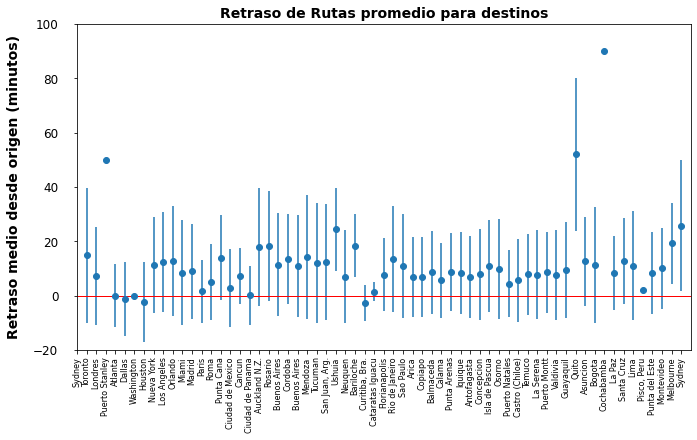

In [35]:
mean_val = [] ; std_val = [] ; x_label = []

i = 0
for route, liste_retards in liste_trajet:
    #_____________________________________________
    # I set the labels as the airport from origin
    index = route.split('-')[1]
    x_label.append(identify_airportd[index]) 
    #______________________________________________________________________________
    # I put a threshold on delays to prevent that high values take too much weight
    trajet2 = [min(90, s) for s in liste_retards]
    #________________________________________
    # I compute mean and standard deviations
    mean_val.append(scipy.mean(trajet2))
    std_val.append(scipy.std(trajet2))
    i += 1
#________________
# Plot the graph
fig, ax = plt.subplots(figsize=(11,6))
std_min = [ min(15 + mean_val[i], s) for i,s in enumerate(std_val)] 
ax.errorbar(list(range(i)), mean_val, yerr = std_val, fmt='o') 
ax.set_title('Retraso de Rutas promedio para destinos',
             fontsize=14, weight = 'bold')
plt.ylabel('Retraso medio desde origen (minutos)', fontsize=14, weight = 'bold', labelpad=12)

imin, imax = -1, 63
plt.xlim(imin, imax) ; plt.ylim(-20, 100)
liste_ticks = [imin]
for j in range(imin+1,imax):
    if x_label[j] == x_label[j-1]: continue
    liste_ticks.append(j)



ax.set_xticks(liste_ticks)
ax.set_xticklabels([x_label[int(x)] for x in ax.get_xticks()], rotation = 90, fontsize = 8)
plt.setp(ax.get_yticklabels(), fontsize=12, rotation = 0)
ax.tick_params(axis='y', which='major', pad=15)
plt.hlines(y= 0, xmin=-1, xmax= 70, color='red', linestyle ='-', linewidth = 1)
plt.show()

Las grafica muestra vuelos con retraso mayor a 15 minutos, por tipo de vuelo y periodo del dia

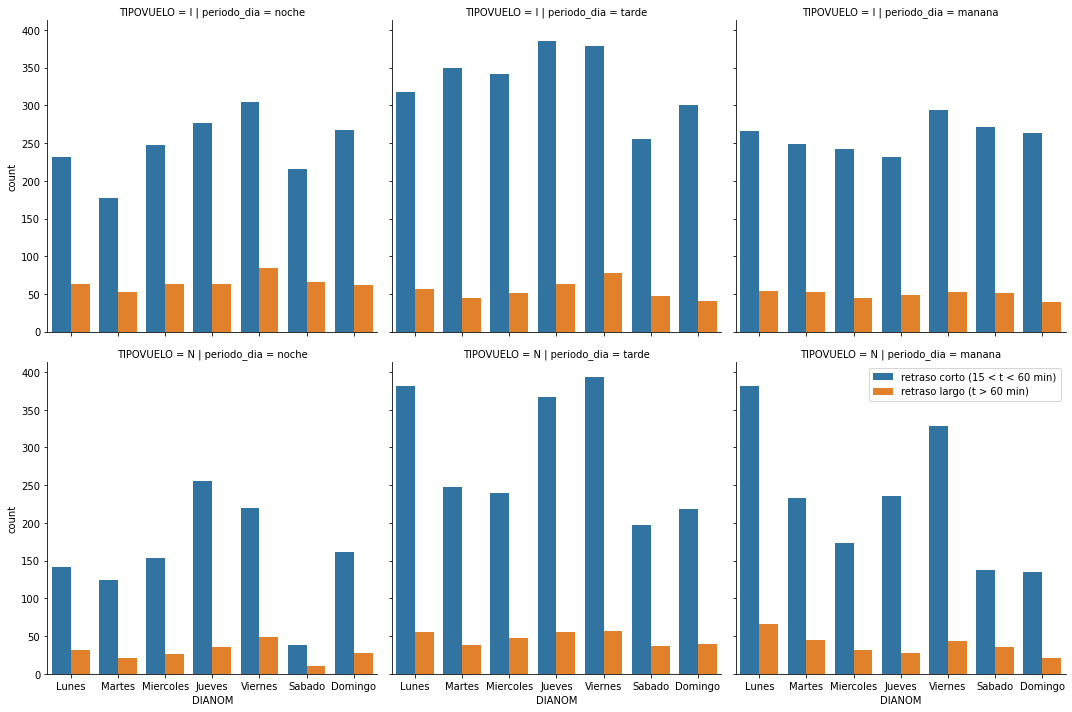

In [36]:
sns.catplot(x='DIANOM', hue='dif_nivel', data=df[df.atraso_15==1],
    col='periodo_dia', kind='count', row='TIPOVUELO', legend=False, 
    order=['Lunes', 'Martes', 'Miercoles', 'Jueves', 'Viernes', 'Sabado', 'Domingo'])
L = plt.legend()
L.get_texts()[0].set_text('retraso corto (15 < t < 60 min)')
L.get_texts()[1].set_text('retraso largo (t > 60 min)')

La grafica muestra vuelos en temporada alta, divididos en internacional o nacional, y periodo de dia

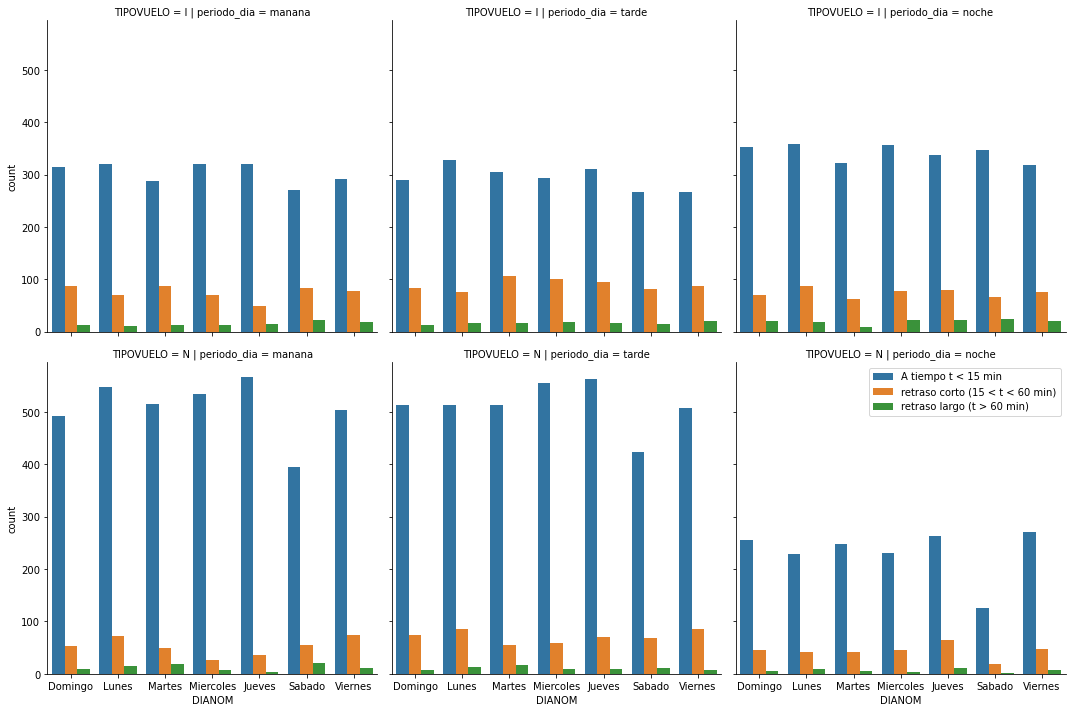

In [37]:
sns.catplot(x='DIANOM', hue='dif_nivel', data=df[df.temporada_alta==1],
    col='periodo_dia', kind='count', row='TIPOVUELO', legend=False,
           col_order = ['manana', 'tarde', 'noche']) 
L = plt.legend()
L.get_texts()[0].set_text('A tiempo t < 15 min')
L.get_texts()[1].set_text('retraso corto (15 < t < 60 min)')
L.get_texts()[2].set_text('retraso largo (t > 60 min)')

In [38]:
def tasa_retraso(y, x='dif_min'): # tasa # filtro
    fig = plt.figure(1, figsize=(10,14))
    ax5=fig.subplots()
    df6 = df[df.dif_min>=0].groupby(y)[x].sum()/df[df.dif_min>=0].groupby(y)[x].count()
    df6.sort_values(ascending=False)
    df6 = df6.reset_index()
    df6 = df6.sort_values(x, ascending=False)
    z = sns.barplot(y=y, x=x,
    data=df6, linewidth = 0.5)

La siguiente grafica muestra la tasa de atraso por destino

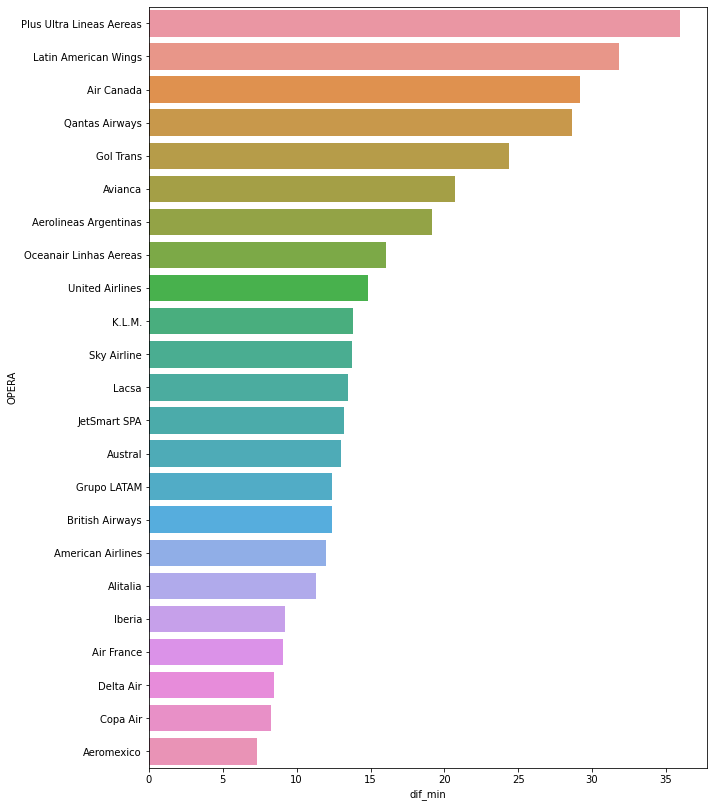

In [45]:
tasa_retraso('OPERA')

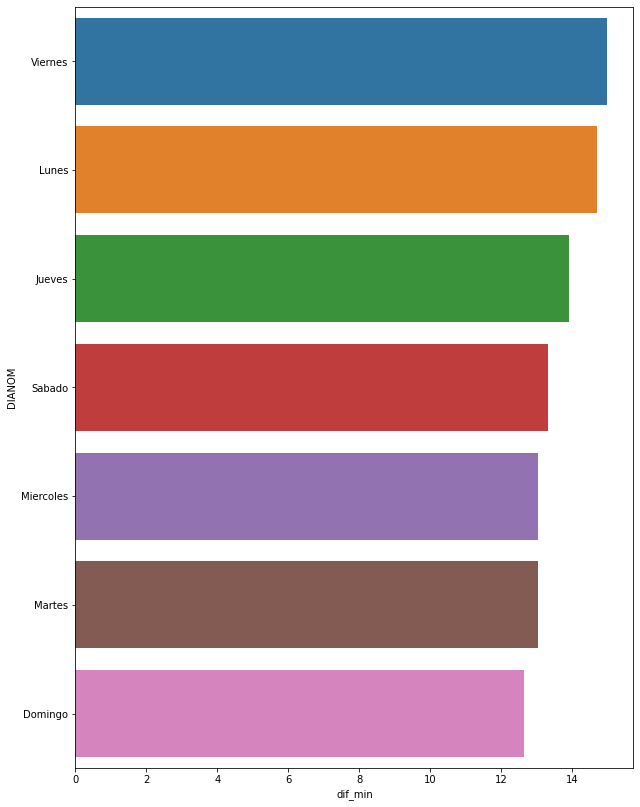

In [39]:
tasa_retraso('DIANOM')

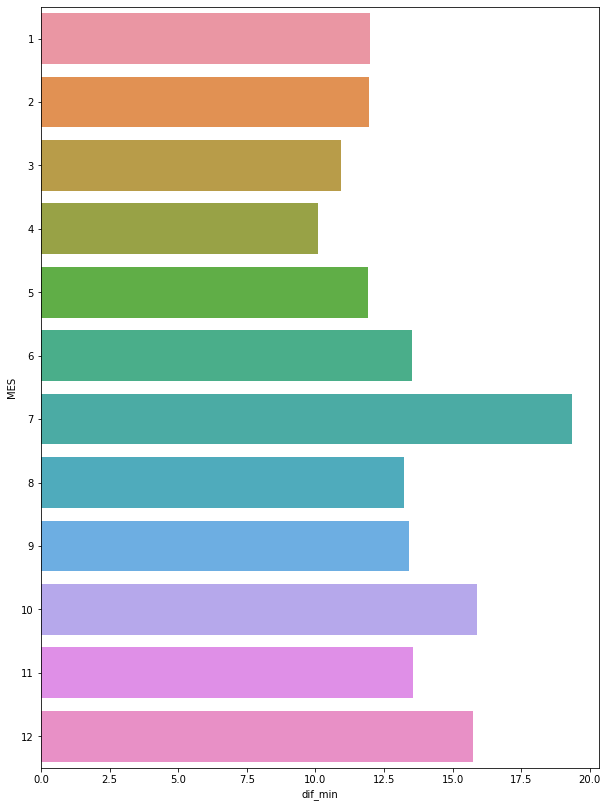

In [40]:
tasa_retraso('MES')

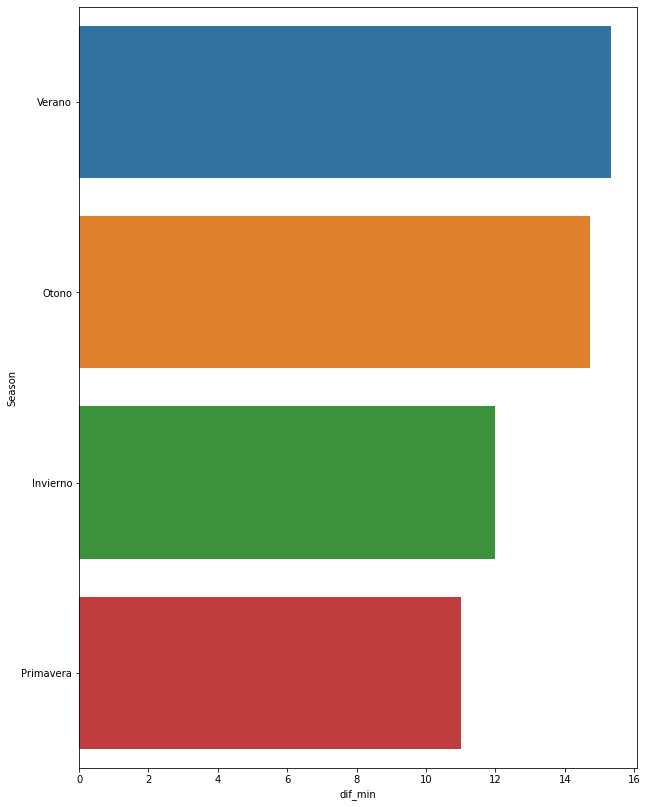

In [46]:
tasa_retraso('Season')

1.  C mo se distribuyen los datos?  Que te llama la atencion o cual es tu conclusion sobre esto?

    * El 60% de los datos son de Grupo LATAM (60%), seguido por Sky Airlines(21%)
    * Hay mayor cantidad de vuelos en la manana y en la tarde que en la noche
    * El mayor numero de vuelos se encuentra en Primavera-Verano
    * Podemos graficar el tiempo de retraso de los vuelos con una distribucion exponencial
    * Igualmente, con la grafica de errores podemos ver la desviacion de retraso de cada destino y su tiempo promedio de retraso.
2.  Como se compone la tasa de atraso por destino, aerol nea, mes del aNo, dIa de la semana, temporada, tipo de vuelo?
    * La tasa de atraso por destino se encuentra entre 0 y 40 minutos por destino, el destino con mayor tasa es Cochabamba pero solo existe un record con ese vuelo.
    * La Aerolinea con mayor tasa de retraso es Plus Ultra Linea Aereas, seguido por Latin American Wings y Air Canada
    * En el mes de Julio existe la mayor tasa de retraso, y los dias viernes
    
3.  Que  variables esperar as que m s influyeran en predecir atrasos?
    * Las aereas que espero que influyan en el destino son, periodo_dia, DIANOM, Destino y Temporada alta.

In [47]:
# df.to_csv('Clean_SCL.csv', index=False)